In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix


import lightgbm as lgb


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows=100
pd.options.display.max_columns=250

#### Чтение и обзор данных

In [2]:
def read_data(path):
    df = pd.read_csv(path)
    print(f'Shape: {df.shape}')
    return df

In [3]:
train_df = read_data('data/train.csv')
train_df.head(3)

Shape: (595212, 59)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0


In [4]:
test_df = read_data('data/test.csv')
test_df.head(3)

Shape: (892816, 58)


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [6]:
train_df.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.0000

Данные анонимизированы, но по названию можно понять, что колонки с постфиксом cat - категориальные, а с постфиксом bin - бинарные.

Проверим эту гипотезу.

### Категориальные признаки

In [7]:
category_features = train_df.filter(like='cat').columns.to_list()

train_df[category_features].nunique().sort_values()

ps_car_08_cat      2
ps_ind_04_cat      3
ps_car_02_cat      3
ps_car_03_cat      3
ps_car_05_cat      3
ps_car_07_cat      3
ps_car_10_cat      3
ps_ind_02_cat      5
ps_car_09_cat      6
ps_ind_05_cat      8
ps_car_04_cat     10
ps_car_01_cat     13
ps_car_06_cat     18
ps_car_11_cat    104
dtype: int64

#### Разобъем категориальные признаки на группы по суффиксам -car- или -ind-

In [8]:
category_features_car = train_df[category_features].filter(like='car').columns.to_list()
category_features_ind = train_df[category_features].filter(like='ind').columns.to_list()

In [9]:
for col in category_features_car:
    print(train_df[col].value_counts())

 11    207573
 7     179247
 6      62393
 10     50087
 4      26174
 9      20323
 5      18142
 8      15093
 3       6658
 0       5904
 2       2144
 1       1367
-1        107
Name: ps_car_01_cat, dtype: int64
 1    493990
 0    101217
-1         5
Name: ps_car_02_cat, dtype: int64
-1    411231
 1    110709
 0     73272
Name: ps_car_03_cat, dtype: int64
0    496581
1     32115
2     23770
8     20598
9     19034
6      1560
3       640
5       545
4       230
7       139
Name: ps_car_04_cat, dtype: int64
-1    266551
 1    172667
 0    155994
Name: ps_car_05_cat, dtype: int64
11    131527
1     118386
0     110420
14     59253
10     33466
4      31136
15     21732
6      20951
9      17617
7      16158
3      11997
13      6246
17      4935
16      4582
12      2386
2       1607
8       1412
5       1401
Name: ps_car_06_cat, dtype: int64
 1    553148
 0     30575
-1     11489
Name: ps_car_07_cat, dtype: int64
1    495264
0     99948
Name: ps_car_08_cat, dtype: int64
 2    353482

In [10]:
for col in category_features_ind:
    print(train_df[col].value_counts())

 1    431859
 2    123573
 3     28186
 4     11378
-1       216
Name: ps_ind_02_cat, dtype: int64
 0    346965
 1    248164
-1        83
Name: ps_ind_04_cat, dtype: int64
 0    528009
 6     20662
 4     18344
 1      8322
 3      8233
-1      5809
 2      4184
 5      1649
Name: ps_ind_05_cat, dtype: int64


Похоже, что пропуски были, но их заменили на "-1". 

Возвращаем наны, чтобы потом проверить разные способы заполнения пропусков.

#### Сравнение основных статистик обучающей и тестовой выборок

In [11]:
# plt.figure(figsize=(20,300))

# for num, feature in enumerate(category_features):
#     plt.subplot(50,4,num+1)
#     plt.title(feature)
    
#     train_stat = train_df[feature].describe().drop('count', axis=0)
#     test_stat = test_df[feature].describe().drop('count', axis=0)
    
#     sns.barplot(x=train_stat.index, y=train_stat.values, alpha=0.6, color='r')
#     sns.barplot(x=test_stat.index, y=test_stat.values, alpha=0.3, color='b')
    
# plt.show()

Все признаки одинаково распределены в трейне и тесте. Это хорошо.

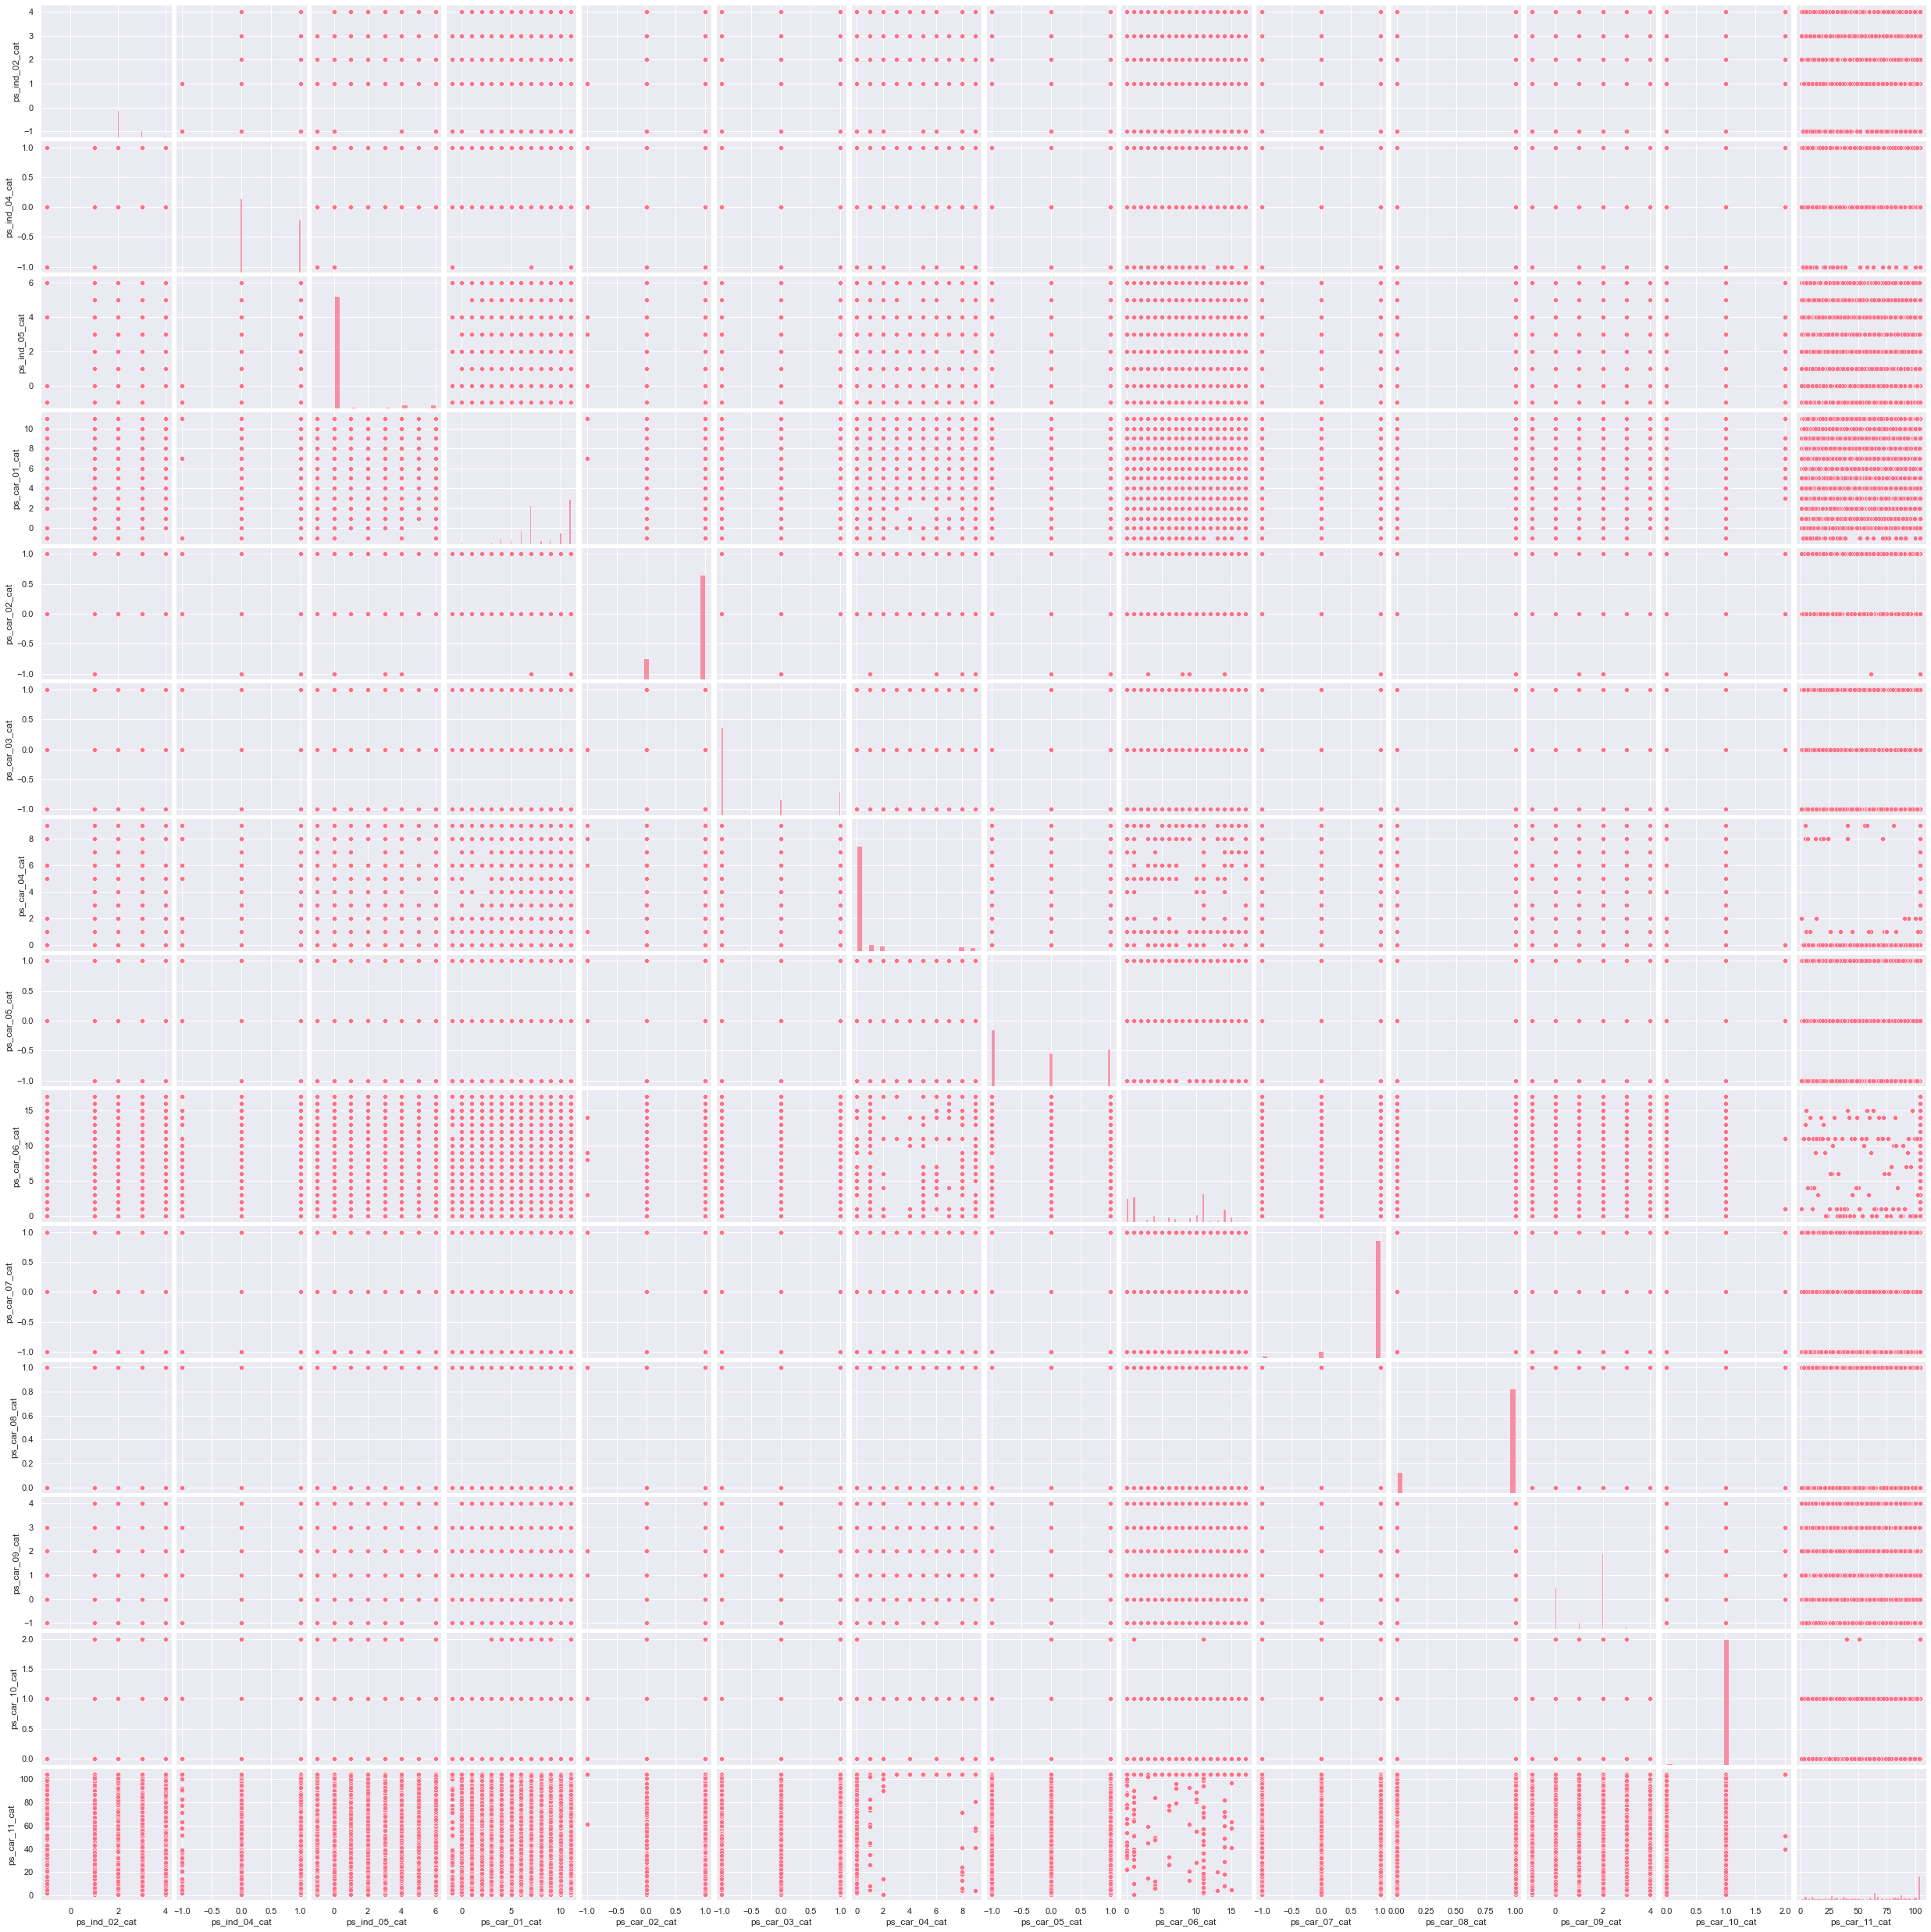

In [12]:
sns.pairplot(train_df[category_features]);

### Бинарные признаки

In [13]:
binary_features = train_df.filter(like='bin').columns.tolist()
binary_features_ind = train_df[binary_features].filter(like='ind').columns.tolist()
binary_features_calc = train_df[binary_features].filter(like='calc').columns.tolist()

In [14]:
train_df[binary_features].nunique().sort_values()

ps_ind_06_bin     2
ps_calc_18_bin    2
ps_calc_17_bin    2
ps_calc_16_bin    2
ps_calc_15_bin    2
ps_ind_18_bin     2
ps_ind_17_bin     2
ps_calc_19_bin    2
ps_ind_16_bin     2
ps_ind_12_bin     2
ps_ind_11_bin     2
ps_ind_10_bin     2
ps_ind_09_bin     2
ps_ind_08_bin     2
ps_ind_07_bin     2
ps_ind_13_bin     2
ps_calc_20_bin    2
dtype: int64

#### Сравнение основных статистик обучающей и тестовой выборок

In [15]:
# plt.figure(figsize=(20,300))

# for num, feature in enumerate(binary_features):
#     plt.subplot(50,4,num+1)
#     plt.title(feature)
    
#     train_stat = train_df[feature].describe().drop('count', axis=0)
#     test_stat = test_df[feature].describe().drop('count', axis=0)
    
#     sns.barplot(x=train_stat.index, y=train_stat.values, alpha=0.6, color='r')
#     sns.barplot(x=test_stat.index, y=test_stat.values, alpha=0.3, color='b')
    
# plt.show()

Бинарные признаки тоже одинаково распределены в трейне и тесте.

Для экономии ресурсов изменим тип данных у этих признаков.

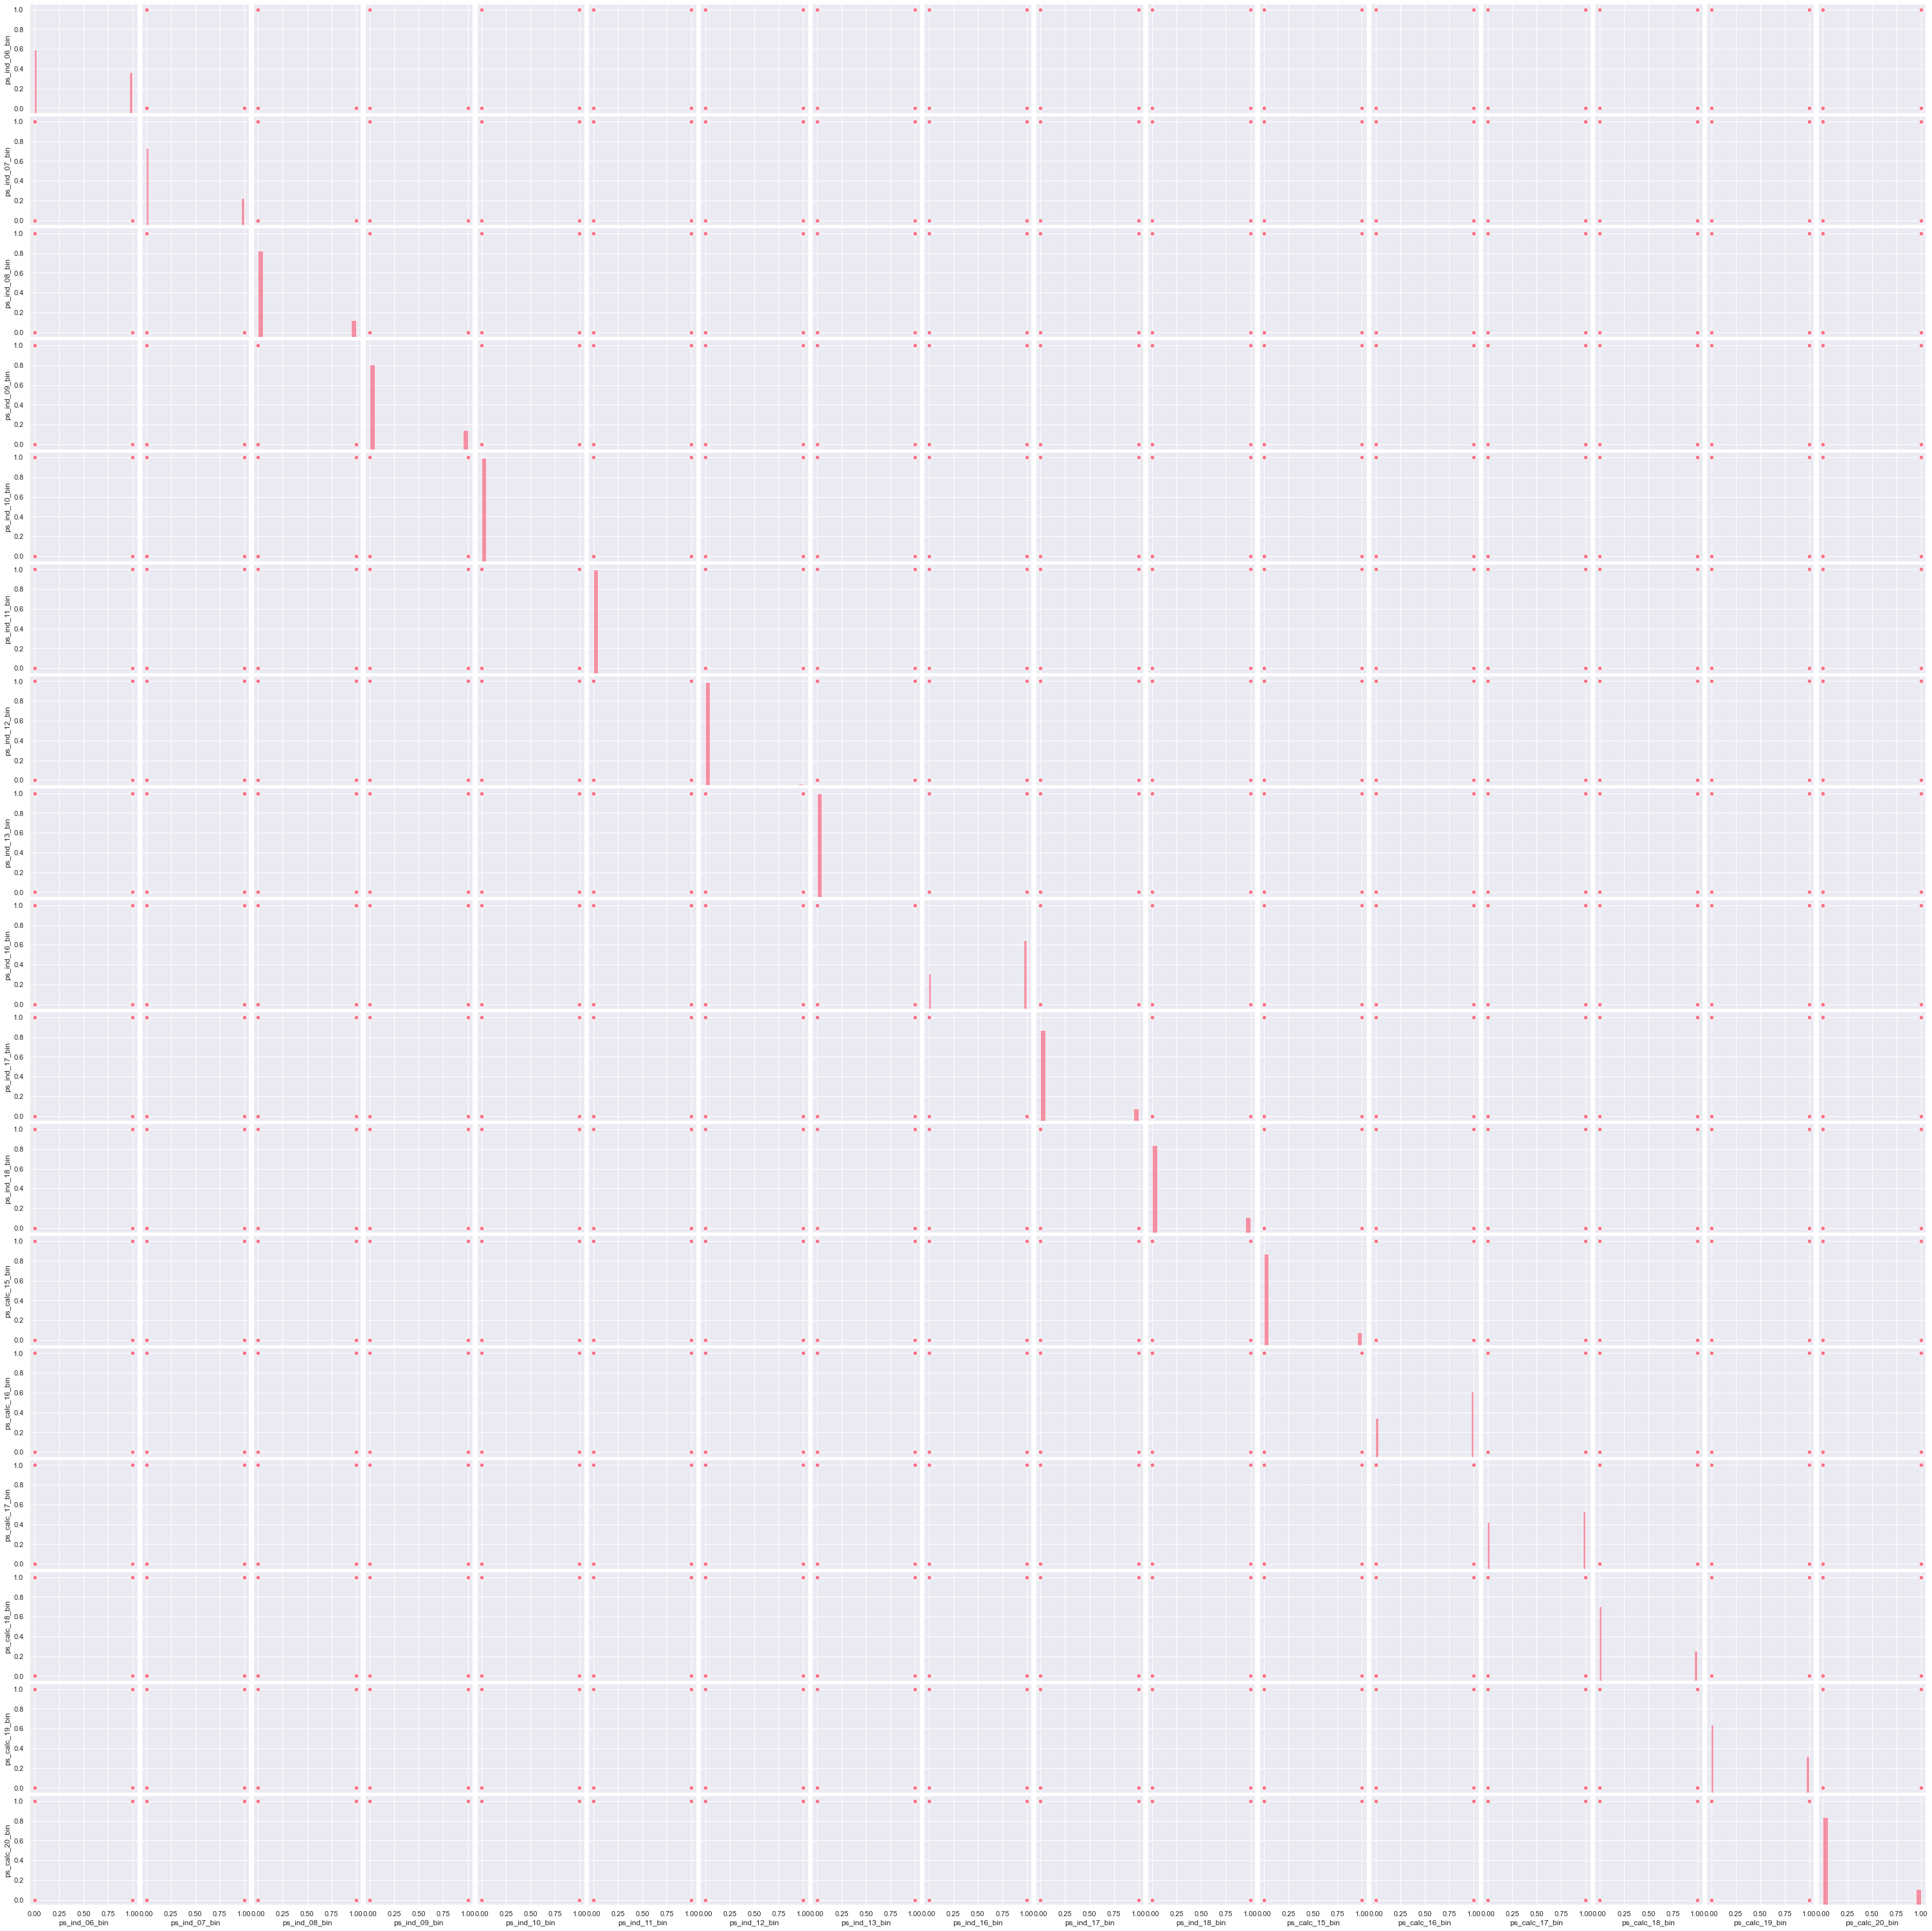

In [16]:
sns.pairplot(train_df[binary_features]);

#### Количественные признаки

In [17]:
numeric_features = [col for col in train_df.columns if col not in (
    train_df.filter(like='cat').columns.tolist() + train_df.filter(like='bin').columns.tolist() + ['id', 'target'])]

In [18]:
numeric_features_ind = train_df[numeric_features].filter(like='ind').columns.tolist()
numeric_features_reg = train_df[numeric_features].filter(like='reg').columns.tolist()
numeric_features_calc = train_df[numeric_features].filter(like='calc').columns.tolist()
numeric_features_car = train_df[numeric_features].filter(like='car').columns.tolist()

In [19]:
train_df[numeric_features_ind].nunique().sort_values()

ps_ind_14     5
ps_ind_01     8
ps_ind_03    12
ps_ind_15    14
dtype: int64

In [20]:
train_df[numeric_features_reg].nunique().sort_values()

ps_reg_01      10
ps_reg_02      19
ps_reg_03    5013
dtype: int64

In [21]:
train_df[numeric_features_calc].nunique().sort_values()

ps_calc_04     6
ps_calc_05     7
ps_calc_09     8
ps_calc_01    10
ps_calc_02    10
ps_calc_03    10
ps_calc_07    10
ps_calc_06    11
ps_calc_08    11
ps_calc_12    11
ps_calc_13    14
ps_calc_11    20
ps_calc_14    24
ps_calc_10    26
dtype: int64

In [22]:
train_df[numeric_features_car].nunique().sort_values()

ps_car_11        5
ps_car_15       15
ps_car_12      184
ps_car_14      850
ps_car_13    70482
dtype: int64

Признаки, у которых количество уникальных значений меньше 50, очень похожи на категориальные, возможно, порядковые.

#### Выделим дискретные признаки

In [23]:
float_features = train_df.select_dtypes(include=['float']).columns.tolist()

In [24]:
round((
    len(train_df[float_features]) - train_df[float_features].count()) / 
    len(train_df[float_features]) * 100, 2).sort_values(ascending=False)

ps_calc_03    0.0
ps_calc_02    0.0
ps_calc_01    0.0
ps_car_15     0.0
ps_car_14     0.0
ps_car_13     0.0
ps_car_12     0.0
ps_reg_03     0.0
ps_reg_02     0.0
ps_reg_01     0.0
dtype: float64

In [25]:
discrete = [
    'ps_car_11',
    'ps_car_12',
    'ps_calc_02',
    'ps_car_13',
    'ps_car_02_cat',
    'ps_car_15',
    'ps_reg_02',
    'ps_reg_01',
    'ps_calc_01',
    'ps_calc_03'
]

### Распределение количественных признаков

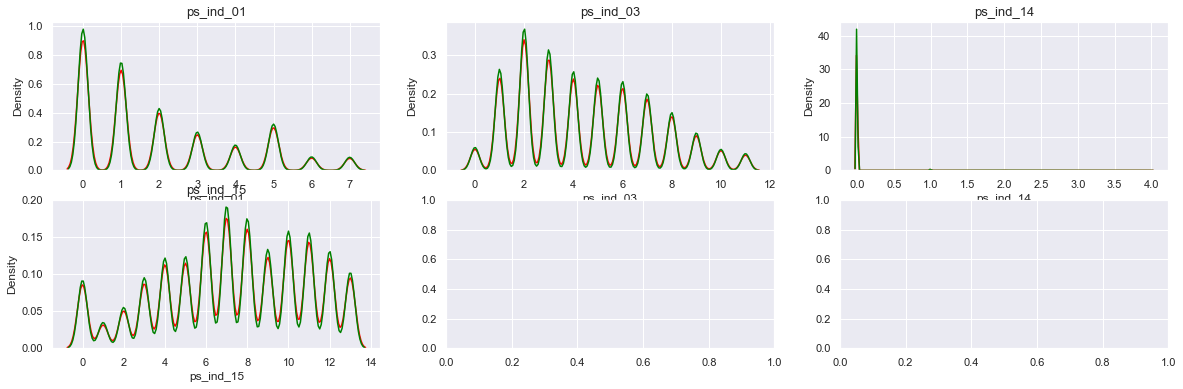

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(20, 6))

for num, feature in enumerate(numeric_features_ind):
    sns.kdeplot(train_df[feature], ax=axes[num//3, num%3], color="red", label="train")
    sns.kdeplot(test_df[feature], ax=axes[num//3, num%3], color="green", label="test")
    axes[num//3, num%3].set_title(feature, fontsize=13)
plt.show()

In [27]:
train_df[numeric_features_ind].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15
count,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922
std,1.983789,2.699902,0.127545,3.546042
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000
50%,1.000000,4.000000,0.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000
max,7.000000,11.000000,4.000000,13.000000


In [28]:
train_df['ps_ind_14'].value_counts()

0    588832
1      5495
2       744
3       136
4         5
Name: ps_ind_14, dtype: int64

In [29]:
test_df['ps_ind_14'].value_counts()

0    883293
1      8212
2      1103
3       194
4        14
Name: ps_ind_14, dtype: int64

In [30]:
test_df[numeric_features_ind].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15
count,892816.000000,892816.000000,892816.000000,892816.000000
mean,1.902371,4.413734,0.012383,7.296862
std,1.986503,2.700149,0.127251,3.541948
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000
50%,1.000000,4.000000,0.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000
max,7.000000,11.000000,4.000000,13.000000


In [31]:
train_df[numeric_features_ind].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15
count,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922
std,1.983789,2.699902,0.127545,3.546042
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000
50%,1.000000,4.000000,0.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000
max,7.000000,11.000000,4.000000,13.000000


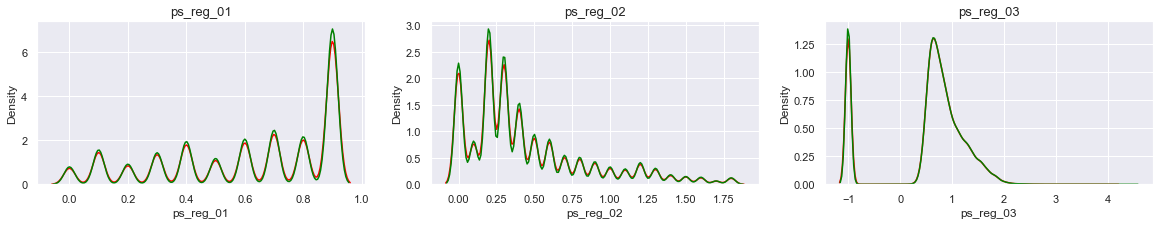

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(20, 3))

for num, feature in enumerate(numeric_features_reg):
    sns.kdeplot(train_df[feature], ax=axes[num%3], color="red", label="train")
    sns.kdeplot(test_df[feature], ax=axes[num%3], color="green", label="test")
    axes[num%3].set_title(feature, fontsize=13)
plt.show()

In [33]:
train_df[numeric_features_reg].describe()

,ps_reg_01,ps_reg_02,ps_reg_03
count,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102
std,0.287643,0.404264,0.793506
min,0.000000,0.000000,-1.000000
25%,0.400000,0.200000,0.525000
50%,0.700000,0.300000,0.720677
75%,0.900000,0.600000,1.000000
max,0.900000,1.800000,4.037945


In [34]:
test_df[numeric_features_reg].describe()

,ps_reg_01,ps_reg_02,ps_reg_03
count,892816.000000,892816.000000,892816.000000
mean,0.611057,0.439868,0.551740
std,0.287699,0.404678,0.794023
min,0.000000,0.000000,-1.000000
25%,0.400000,0.200000,0.524404
50%,0.700000,0.300000,0.721110
75%,0.900000,0.600000,1.002185
max,0.900000,1.800000,4.423517


In [35]:
train_df[numeric_features_reg].describe()

,ps_reg_01,ps_reg_02,ps_reg_03
count,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102
std,0.287643,0.404264,0.793506
min,0.000000,0.000000,-1.000000
25%,0.400000,0.200000,0.525000
50%,0.700000,0.300000,0.720677
75%,0.900000,0.600000,1.000000
max,0.900000,1.800000,4.037945


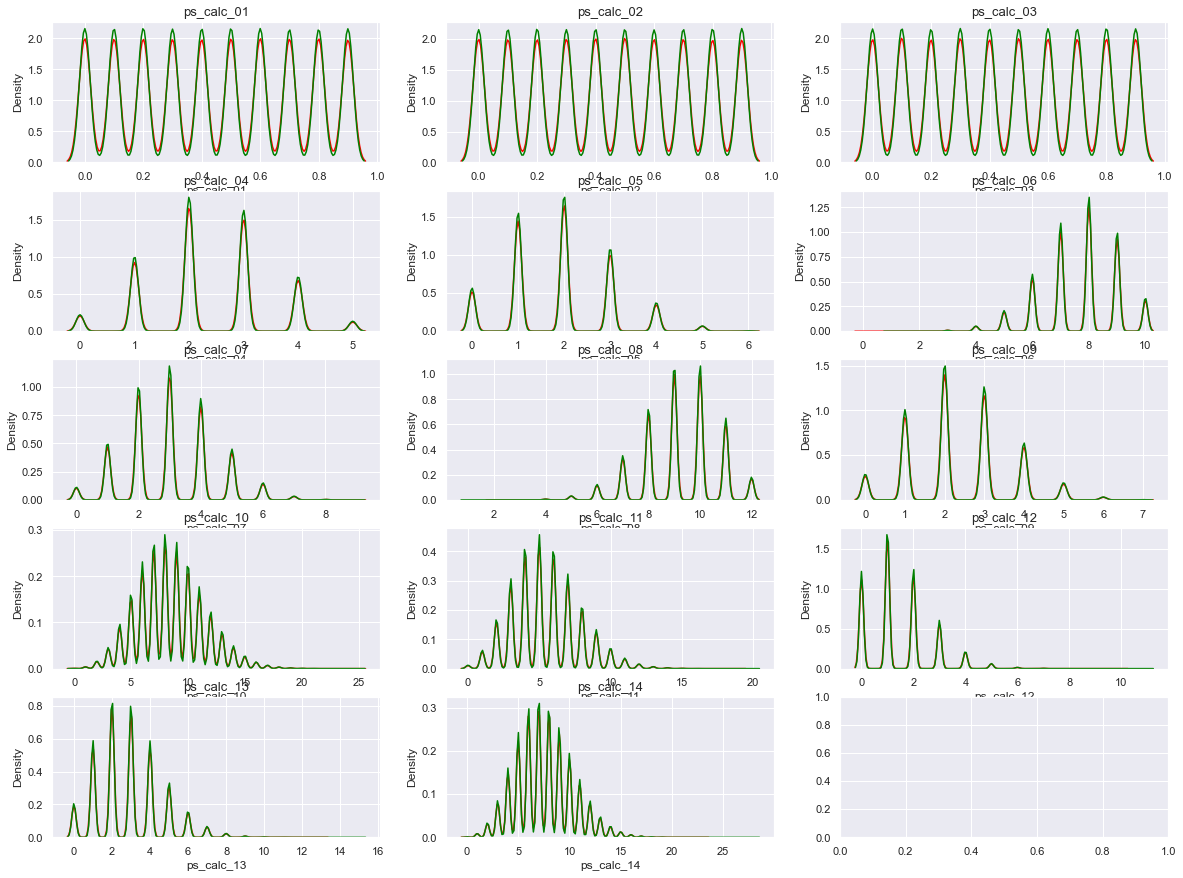

In [36]:
fig, axes = plt.subplots(5, 3, figsize=(20, 15))

for num, feature in enumerate(numeric_features_calc):
    sns.kdeplot(train_df[feature], ax=axes[num//3, num%3], color="red", label="train")
    sns.kdeplot(test_df[feature], ax=axes[num//3, num%3], color="green", label="test")
    axes[num//3, num%3].set_title(feature, fontsize=13)
plt.show()

In [37]:
train_df[numeric_features_calc].describe()

,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,0.500000,0.400000,0.500000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,0.700000,0.700000,0.700000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,0.900000,0.900000,0.900000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [38]:
test_df[numeric_features_calc].describe()

,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,0.449632,0.450453,0.450054,2.371390,1.885328,7.687805,3.009537,9.225854,2.338538,8.443167,5.438478,1.440265,2.875013,7.540367
std,0.287213,0.287373,0.287254,1.116953,1.136763,1.333521,1.415155,1.460560,1.248601,2.906361,2.330081,1.200620,1.694072,2.745882
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,0.400000,0.500000,0.400000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,0.700000,0.700000,0.700000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,0.900000,0.900000,0.900000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,20.000000,11.000000,15.000000,28.000000


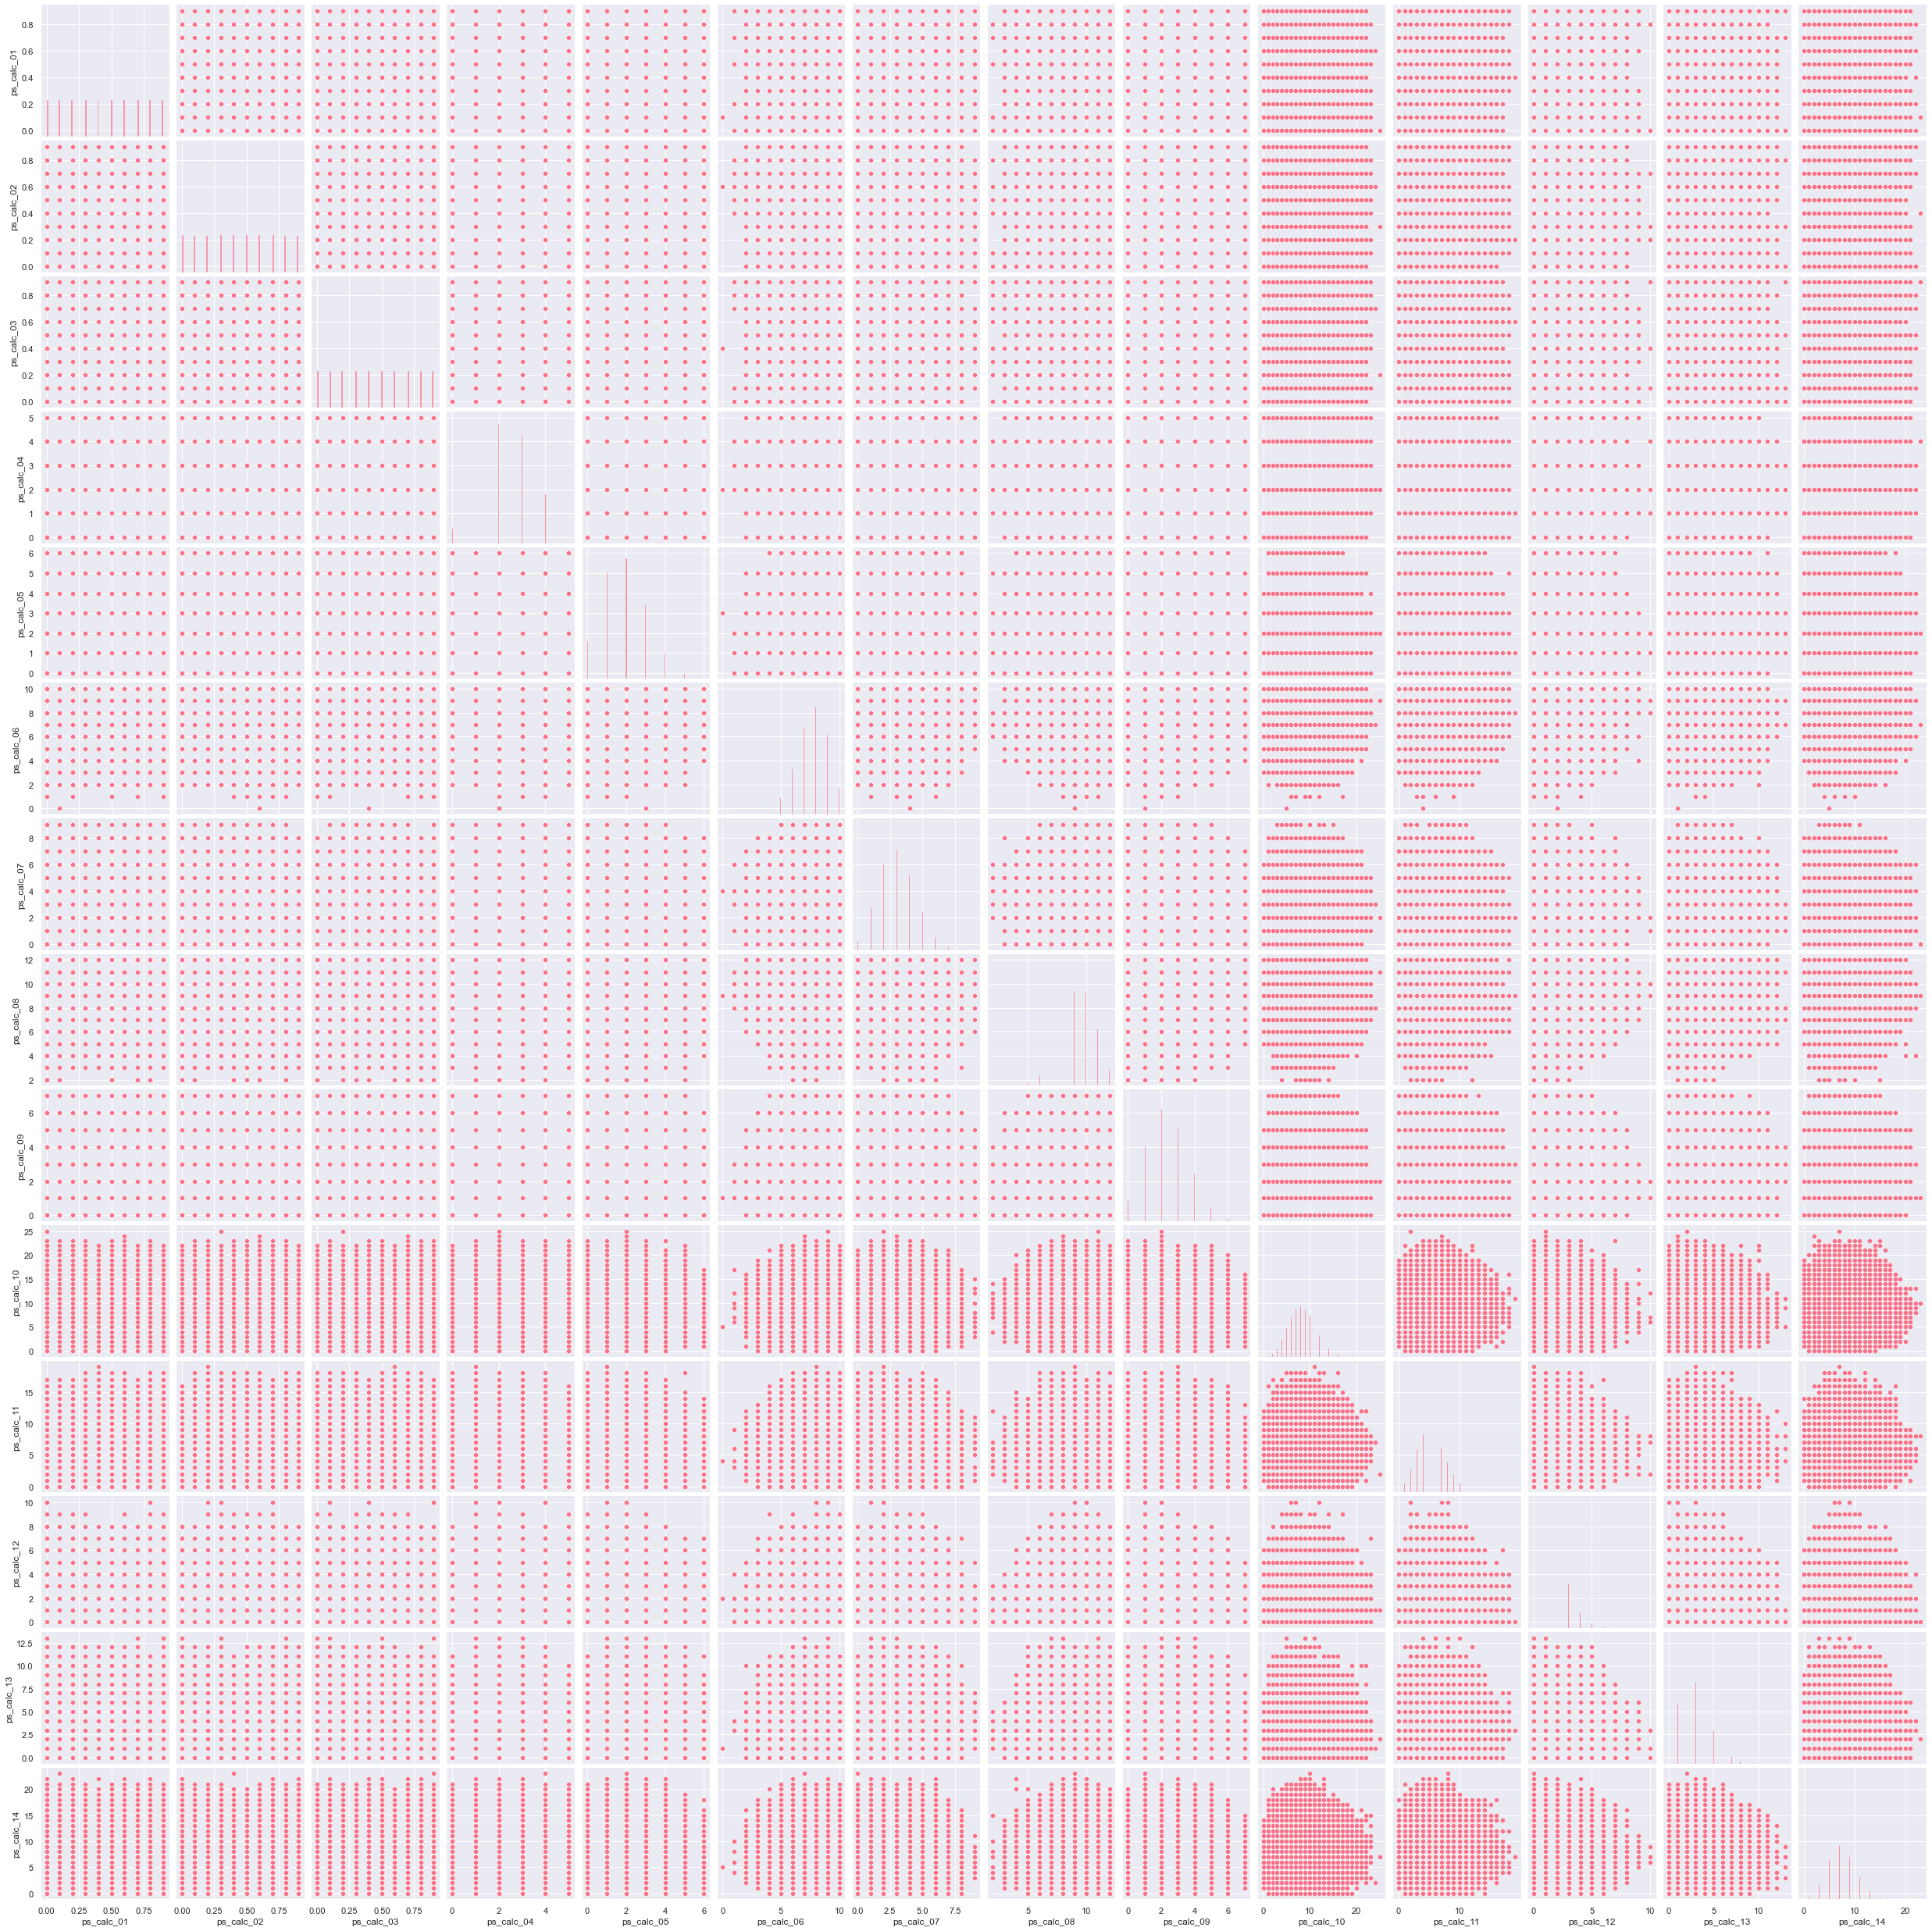

In [39]:
sns.pairplot(train_df[numeric_features_calc]);

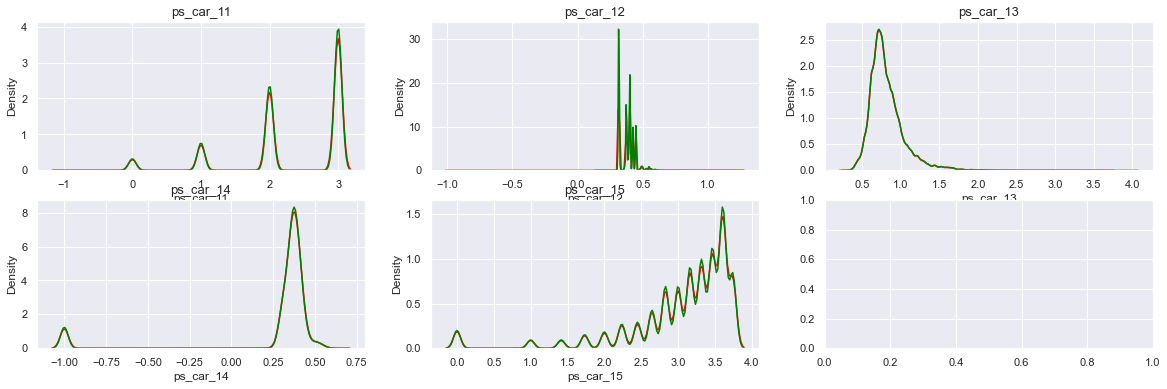

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(20, 6))

for num, feature in enumerate(numeric_features_car):
    sns.kdeplot(train_df[feature], ax=axes[num//3, num%3], color="red", label="train")
    sns.kdeplot(test_df[feature], ax=axes[num//3, num%3], color="green", label="test")
    axes[num//3, num%3].set_title(feature, fontsize=13)
plt.show()

In [41]:
train_df[numeric_features_car].describe()

,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,2.346072,0.379945,0.813265,0.276256,3.065899
std,0.832548,0.058327,0.224588,0.357154,0.731366
min,-1.000000,-1.000000,0.250619,-1.000000,0.000000
25%,2.000000,0.316228,0.670867,0.333167,2.828427
50%,3.000000,0.374166,0.765811,0.368782,3.316625
75%,3.000000,0.400000,0.906190,0.396485,3.605551
max,3.000000,1.264911,3.720626,0.636396,3.741657


In [42]:
test_df[numeric_features_car].describe()

,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,2.346606,0.379957,0.813637,0.276431,3.068325
std,0.831666,0.058385,0.224779,0.356835,0.729005
min,-1.000000,0.141421,0.275778,-1.000000,0.000000
25%,2.000000,0.316228,0.671234,0.333916,2.828427
50%,3.000000,0.374166,0.766081,0.368782,3.316625
75%,3.000000,0.400000,0.906132,0.396485,3.605551
max,3.000000,1.264911,4.031301,0.636396,3.741657


Только 4 признака похожи на неприрывную величину, остальные имеют дискретное распределение.

Плотности распределения признаков на трейне и тесте не совпадают. 

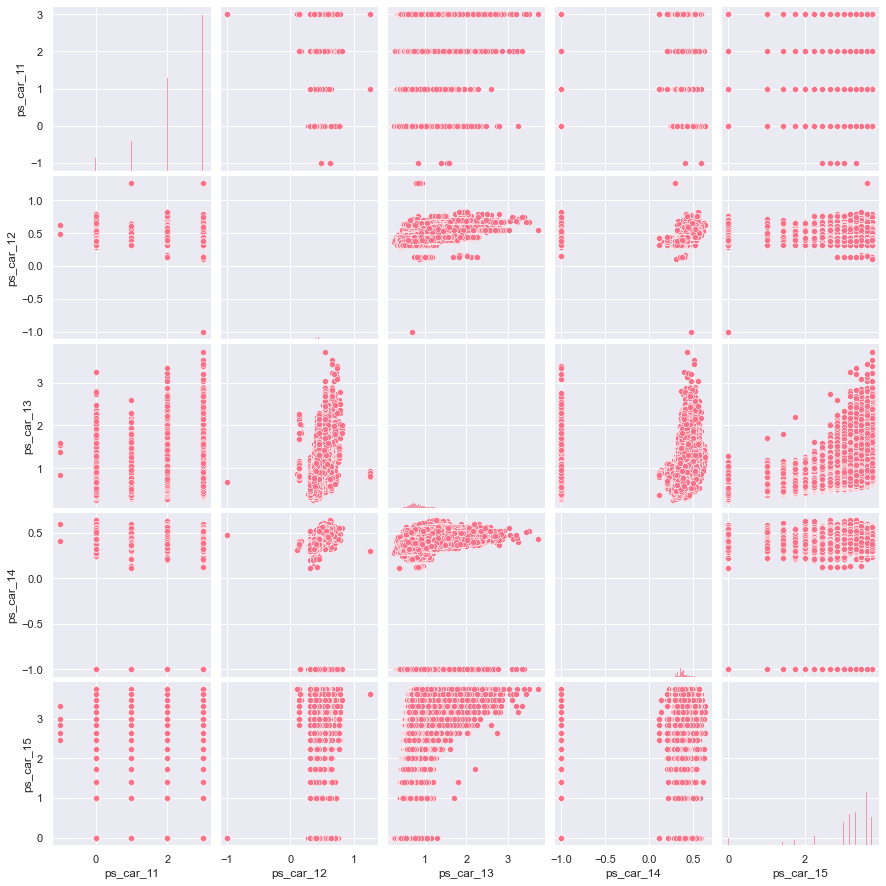

In [43]:
sns.pairplot(train_df[numeric_features_car]);

ps_car_13 и ps_car_15 скоррелированны, скорее всего первый - это возраст, а второй - стаж вождения.

### Линейные связи между признаками

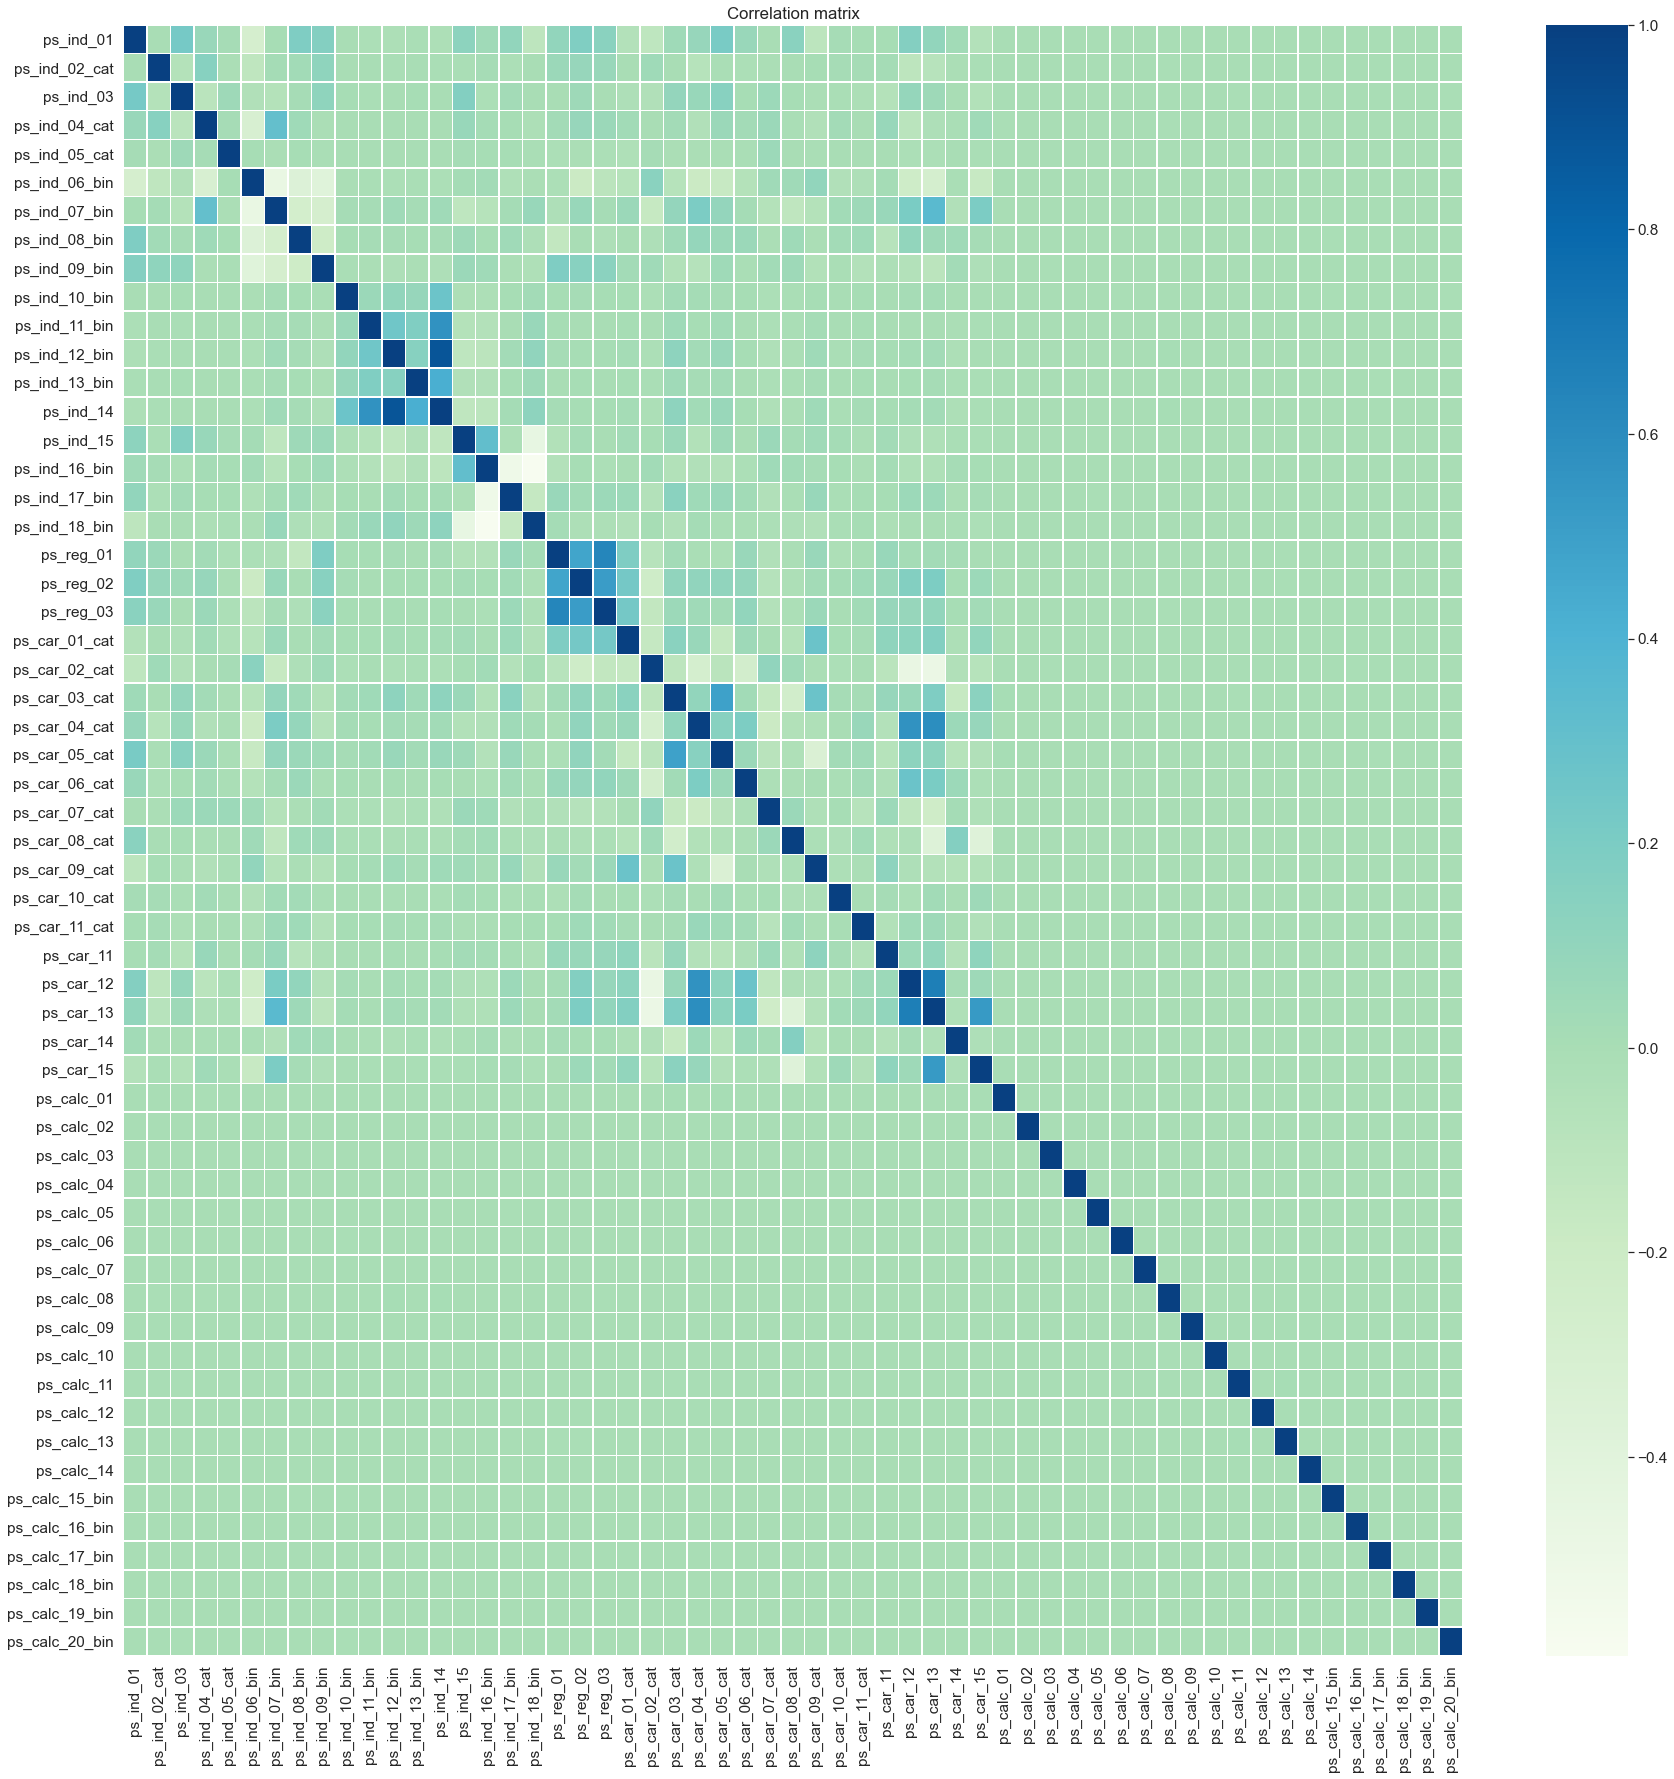

In [44]:
plt.figure(figsize=(30,30))

sns.set(font_scale=1.4)
sns.heatmap(train_df.drop(columns=['id', 'target']).corr(), linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Целевая переменная

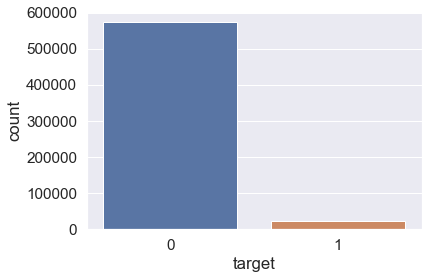

In [45]:
target = "target"
sns.countplot(x=train_df[target]);

In [46]:
round(train_df.loc[train_df['target'] == 1].shape[0] / train_df.shape[0], 2)

0.04

## Зависимость распределения признаков от целевой переменной

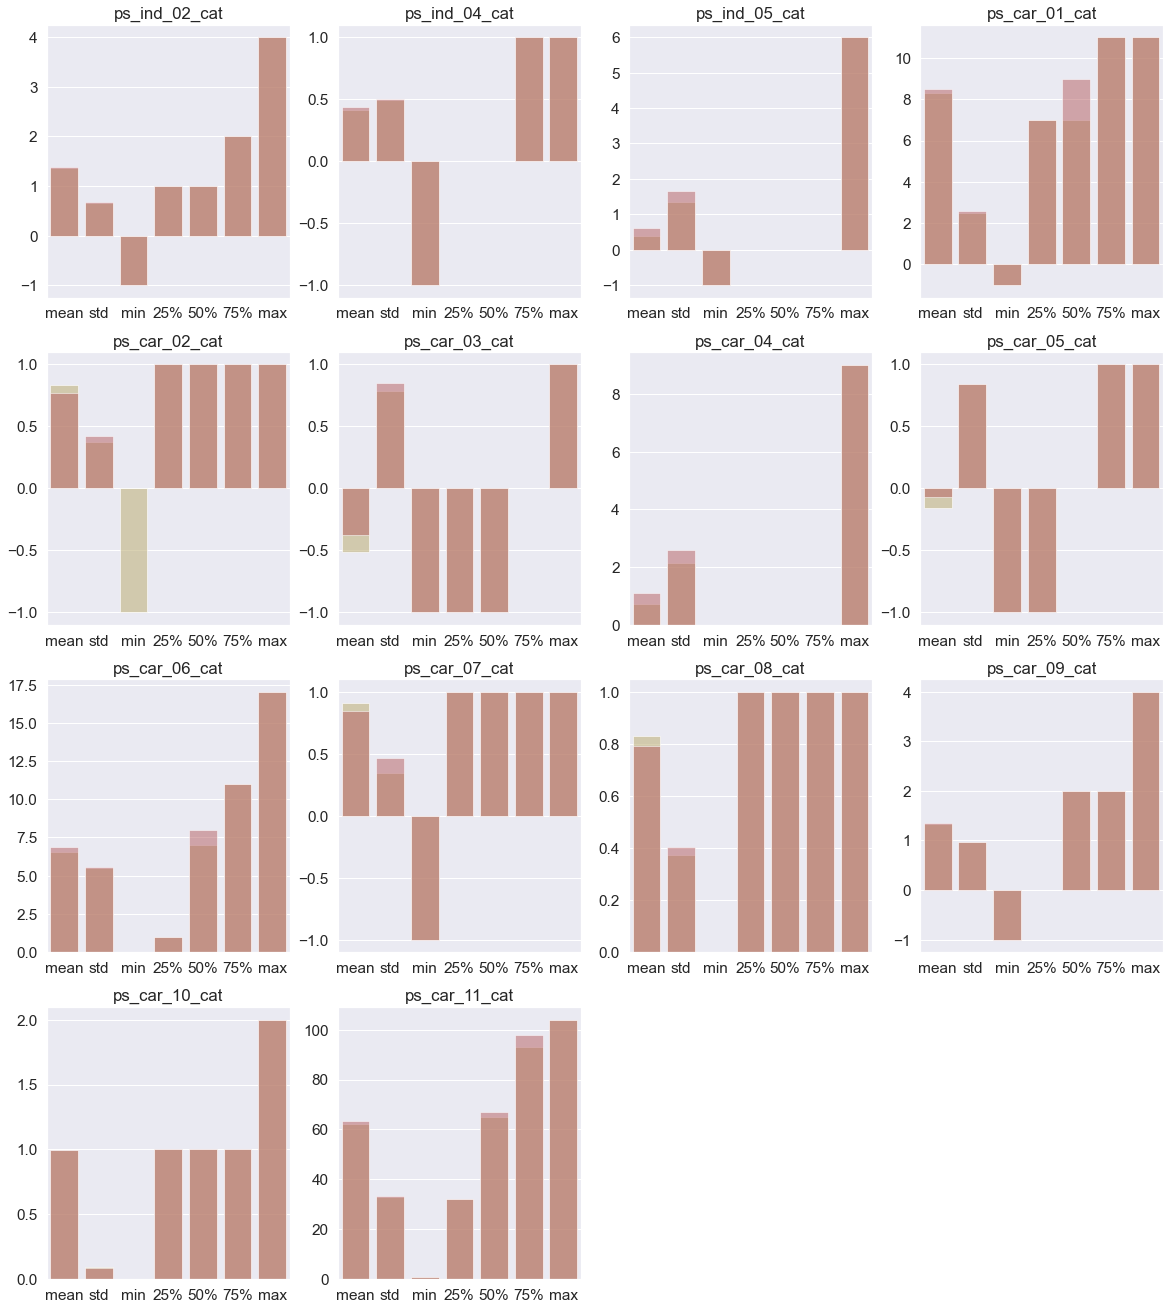

In [47]:
plt.figure(figsize=(20,300))

for num, feature in enumerate(category_features):
    plt.subplot(50,4,num+1)
    plt.title(feature)
    
    train_df_stat_t0 = train_df.loc[train_df[target] == 0, feature].describe().drop('count', axis=0)
    train_df_stat_t1 = train_df.loc[train_df[target] == 1, feature].describe().drop('count', axis=0)
    
    sns.barplot(x=train_df_stat_t0.index, y=train_df_stat_t0.values, alpha=0.6, color='y')
    sns.barplot(x=train_df_stat_t1.index, y=train_df_stat_t1.values, alpha=0.5, color='r')
    
plt.show()

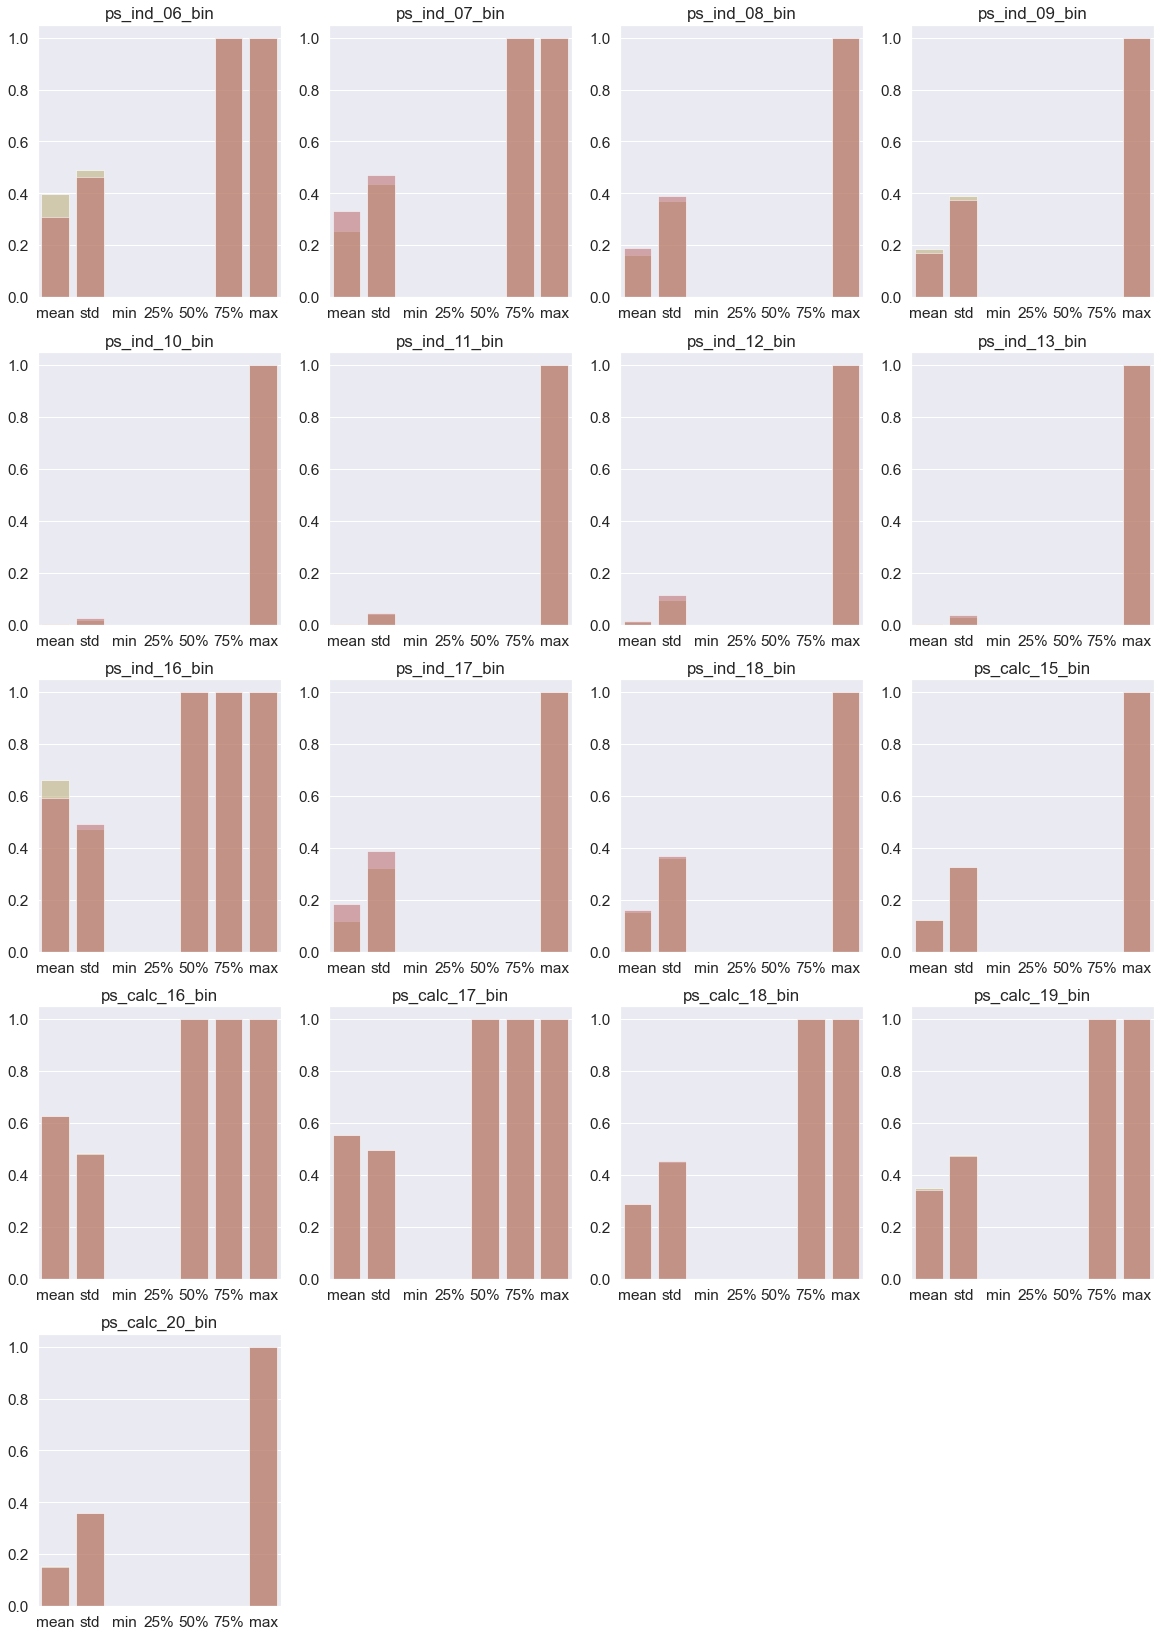

In [48]:
plt.figure(figsize=(20, 300))

for num, feature in enumerate(binary_features):
    plt.subplot(50, 4, num+1)
    plt.title(feature)
    
    train_df_stat_t0 = train_df.loc[train_df[target] == 0, feature].describe().drop('count', axis=0)
    train_df_stat_t1 = train_df.loc[train_df[target] == 1, feature].describe().drop('count', axis=0)
    
    sns.barplot(x=train_df_stat_t0.index, y=train_df_stat_t0.values, alpha=0.6, color='y')
    sns.barplot(x=train_df_stat_t1.index, y=train_df_stat_t1.values, alpha=0.5, color='r')
    
plt.show()

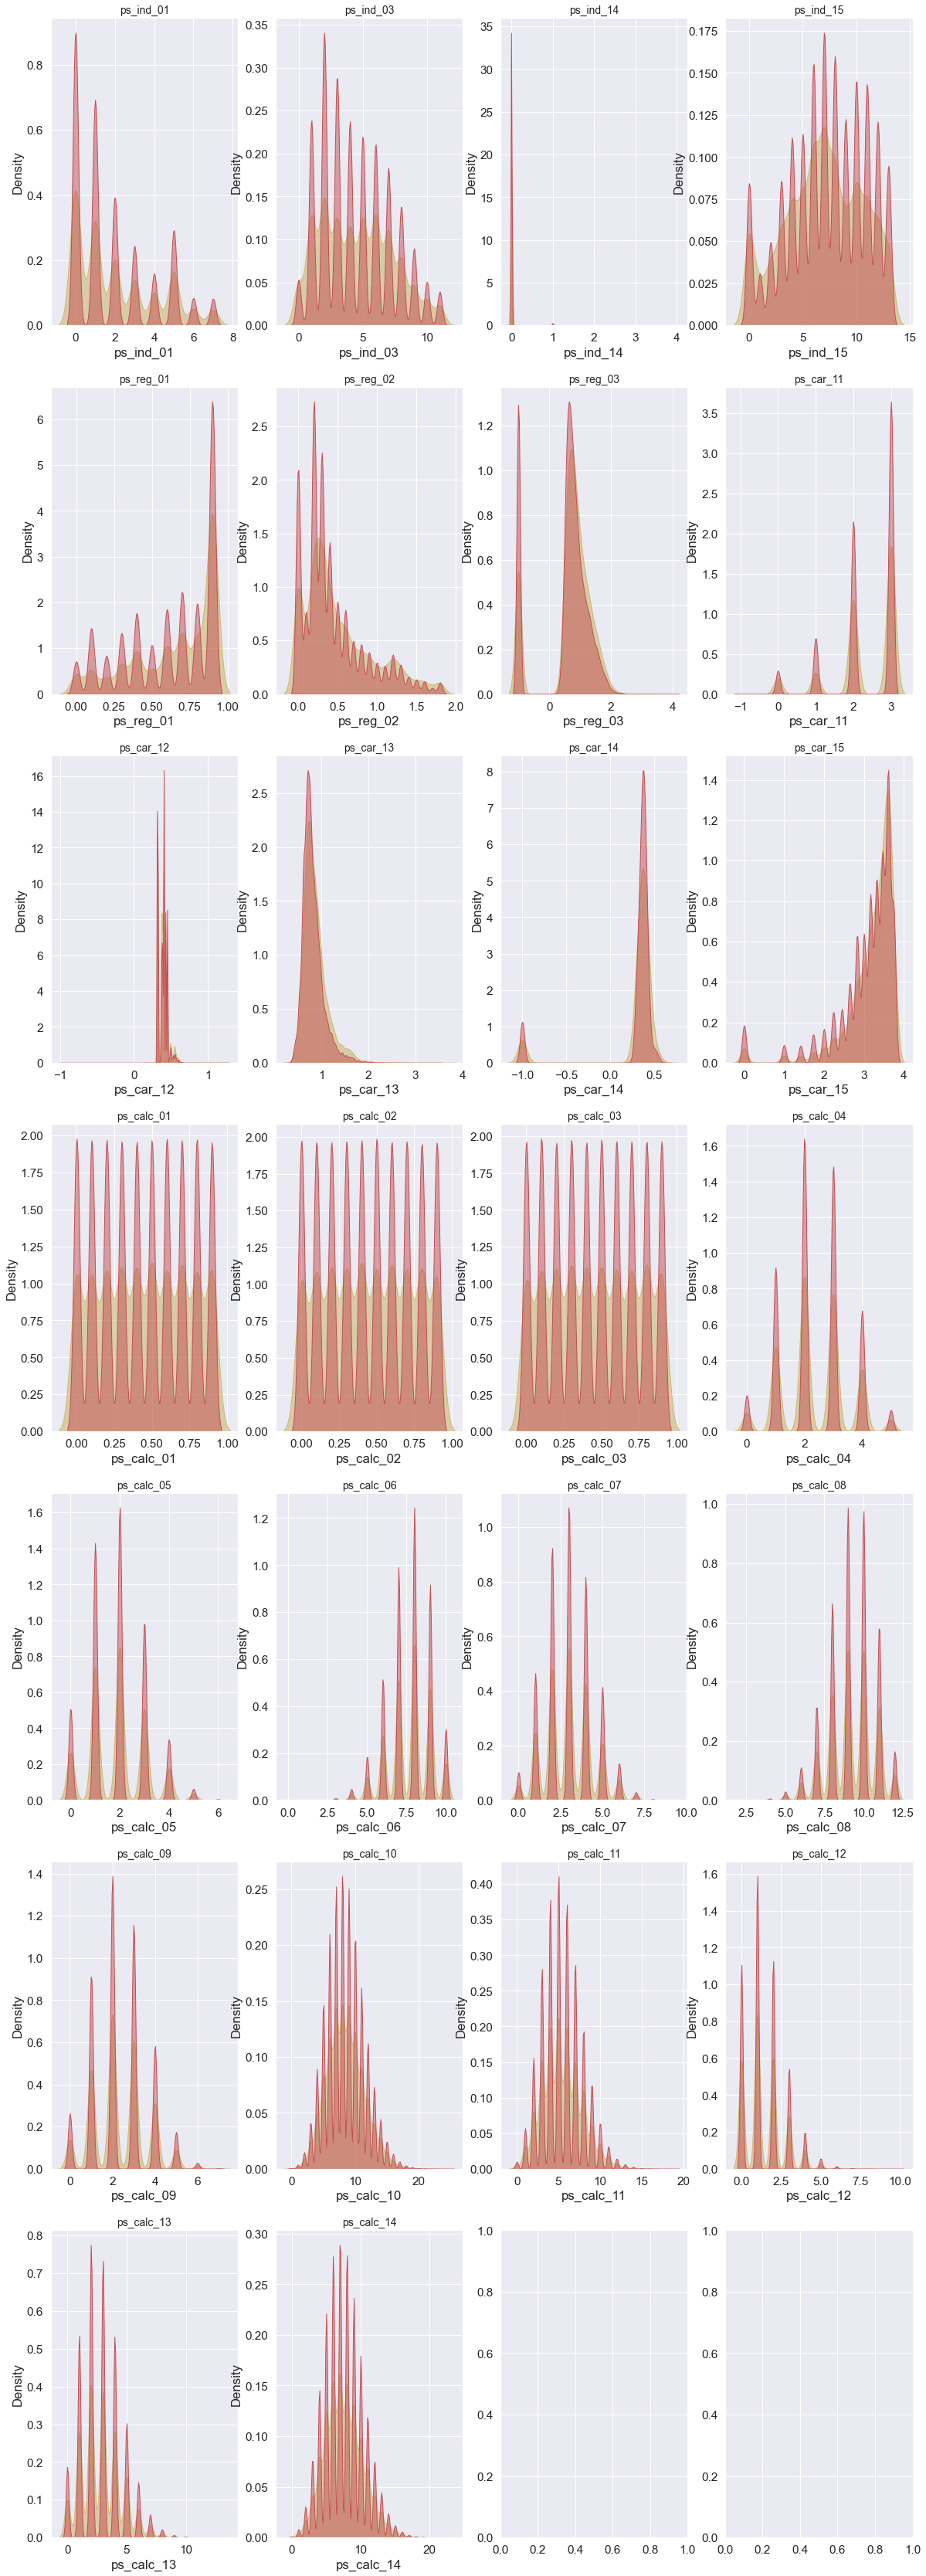

In [49]:
fig, axes = plt.subplots(7, 4, figsize=(20, 60))

for num, feature in enumerate(numeric_features):
    try:
        sns.kdeplot(train_df.loc[train_df[target] == 1, feature], ax=axes[num//4, num%4], 
                    shade=True, alpha=0.6, legend=False, color='y')
        sns.kdeplot(train_df.loc[train_df[target] == 0, feature], ax=axes[num//4, num%4], 
                    shade=True, alpha=0.5, legend=False, color='r')
    except RuntimeError:
        pass
    axes[num//4, num%4].set_title(feature, fontsize=14)
plt.show()

In [51]:
features = [
    category_features_car +
    category_features_ind +
    binary_features_ind +
#     binary_features_calc,
    numeric_features_ind +
    numeric_features_reg +
#     numeric_features_calc,
    numeric_features_car
][0]

In [52]:
features

['ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat',
 'ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15']

### Обработка признаков

In [53]:
def preprocessing(df, binary_features, discrete):
    df[binary_features] = df[binary_features].astype(np.uint8)
    df[discrete] = df[discrete].astype(np.int32)
    df = df.mask(train_df < 0)
    return df


train_df = preprocessing(train_df, binary_features, discrete)
test_df = preprocessing(test_df, binary_features, discrete)

### Балансировка целевой переменной

In [54]:
def balance_df_by_target(df, target):
    '''Return balanced on Target dataset'''
    
    target_counts = df[target].value_counts()

    major_class_name = target_counts.values.argmax()
    minor_class_name = target_counts.values.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / 
                           target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target] == minor_class_name].sample(
                                target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Бейзлайн

In [78]:
# Функция для метрики качества классификатора 
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)


X_train, X_test = train_test_split(
    train_df.drop(columns=['id']),
    test_size=0.25,
    random_state=27
)

X_train = balance_df_by_target(X_train, 'target')
y_train = X_train.pop('target')

y_test = X_test.pop('target')

baseline = lgb.LGBMClassifier(random_state=27, n_jobs=-1, n_estimators=100)
baseline.fit(X_train[features], y_train, 
             eval_set=[(X_test[features], y_test)], 
#              categorical_feature=category_features, 
             verbose=10)

preds = baseline.predict_proba(X_test[features], num_iteration=baseline.best_iteration_)
roc_auc_score(y_test, preds[:, 1])

preds = baseline.predict(X_test[features], num_iteration=baseline.best_iteration_)
print(classification_report(y_test, preds))

[10]	valid_0's binary_logloss: 0.660799
[20]	valid_0's binary_logloss: 0.652189
[30]	valid_0's binary_logloss: 0.647046
[40]	valid_0's binary_logloss: 0.643138
[50]	valid_0's binary_logloss: 0.639909
[60]	valid_0's binary_logloss: 0.637147
[70]	valid_0's binary_logloss: 0.634581
[80]	valid_0's binary_logloss: 0.632146
[90]	valid_0's binary_logloss: 0.629862
[100]	valid_0's binary_logloss: 0.627508
              precision    recall  f1-score   support

           0       0.97      0.67      0.79    143336
           1       0.06      0.51      0.10      5467

    accuracy                           0.67    148803
   macro avg       0.51      0.59      0.45    148803
weighted avg       0.94      0.67      0.77    148803



In [79]:
confusion_matrix(y_test, preds)

array([[96319, 47017],
       [ 2663,  2804]], dtype=int64)

In [80]:
np.round(gini_normalized(y_test, preds), 4)

0.1803

In [65]:
# 0.1797 - without calc, without categorical
# 0.1748 - without categorical
# 0.1602 - without calc
# 0.1598 - all features

## PipeLine